In [ ]:
!apt update && apt install -y python3-opencv
!pip install opencv-python

Get:1 http://security.debian.org/debian-security buster/updates InRelease [65.4 kB]
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease
Fetched 65.4 kB in 0s (221 kB/s)



3 packages can be upgraded. Run 'apt list --upgradable' to see them.



The following packages were automatically installed and are no longer required:
  autoconf automake autotools-dev gfortran gfortran-8 libcaf-openmpi-3
  libcoarrays-dev libcoarrays-openmpi-dev libgfortran-8-dev libsigsegv2 m4
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgl1 libgl1-mesa-dri libgl2ps1.4 libglu1-mesa libglvnd0 libglx-mesa0
  libglx0 libgphoto2-6 libgphoto2-l10n libgphoto2-port12 libgtk-3-0
  libgtk-3-bin libgtk-3-common libhdf5-openmpi-103 libilmbase23
  libjson-glib-1.0-0 libjson-glib-1.0-common liblept5 libnetcdf-c++4
  libopencv-calib3d3.2 libopencv-contrib3.2 libopencv-core3.2
  libopencv-features2d3.2 libopencv-flann3.2

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Original Image')

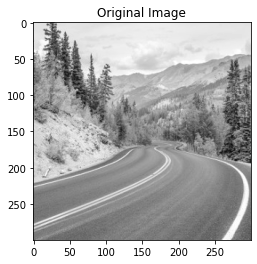

In [ ]:
original_image = cv2.imread("road-1.jpeg", 0)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

Text(0.5, 1.0, 'Smoothed Image with Gaussian Filter')

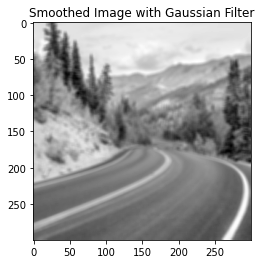

In [ ]:
blurred_image = cv2.GaussianBlur(original_image, (5,5), 10)
plt.imshow(blurred_image, cmap='gray')
plt.title('Smoothed Image with Gaussian Filter')

Text(0.5, 1.0, 'Sobel Y')

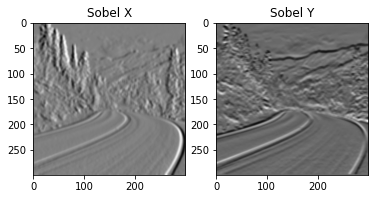

In [ ]:
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude_image = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

plt.subplot(1,2,1)
plt.imshow(sobel_x, cmap = 'gray')
plt.title('Sobel X')

plt.subplot(1,2,2)
plt.imshow(sobel_y,cmap = 'gray')
plt.title('Sobel Y')

Text(0.5, 1.0, 'Gradient Magnitude Image')

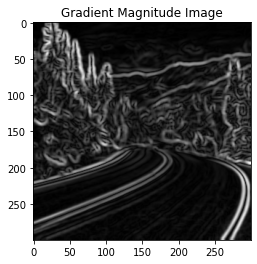

In [ ]:
plt.imshow(gradient_magnitude_image,cmap = 'gray')
plt.title('Gradient Magnitude Image')

In [ ]:
def roi(image):
    bottom_padding = 100 # Front bumper compensation
    height = image.shape[0]
    width = image.shape[1]
    # FYI, below values are highly dependant on the camera calibration i.e what part of the road is actually being captured
    bottom_left = [0, height-bottom_padding]
    bottom_right = [width, height-bottom_padding]
    top_right = [width*1/3, height*1/3]
    top_left = [width*2/3, height*1/3]
    vertices = [np.array([bottom_left, bottom_right, top_left, top_right], dtype=np.int32)]
    mask = np.zeros_like(image)  
    cv2.fillPoly(mask, vertices, 255)
    # plt.imshow(mask, "mask")
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
roi_image = roi(gradient_magnitude_image)

<class 'numpy.ndarray'>


In [ ]:
def averaged_lines(image, lines):
    right_lines = []
    left_lines = []
    for x1,y1,x2,y2 in lines[:, 0]:
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope >= 0: 
            right_lines.append([slope, intercept])
        else:
            left_lines.append([slope, intercept])
            
    def merge_lines(image, lines):
        if len(lines) > 0:
            slope, intercept = np.average(lines, axis=0)
            y1 = image.shape[0]
            y2 = int(y1*(1/2))
            x1 = int((y1 - intercept)/slope)
            x2 = int((y2 - intercept)/slope)
            return np.array([x1, y1, x2, y2])
        
    left = merge_lines(image, left_lines)
    right = merge_lines(image, right_lines)
    return left, right

def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is not None:
        lines = averaged_lines(image, lines)
        for line in lines:
            if line is not None:
                x1,y1,x2,y2 = line
                cv2.line(lines_image, (x1, y1), (x2, y2), (0, 0, 255), 20)
        plot_image(lines_image, "lines")
    return lines_image

In [ ]:
hough_lines_image = hough_lines(roi_image, 0.9, np.pi/180, 100, 100, 50)

error: OpenCV(4.5.1) /tmp/pip-req-build-7m_g9lbm/opencv/modules/imgproc/src/hough.cpp:471: error: (-215:Assertion failed) image.type() == CV_8UC1 in function 'HoughLinesProbabilistic'


In [ ]:
lines = cv2.HoughLines(roi_image, 1, np.pi / 180, 150, None, 0, 0)
print(lines)

error: OpenCV(4.5.1) /tmp/pip-req-build-7m_g9lbm/opencv/modules/imgproc/src/hough.cpp:120: error: (-215:Assertion failed) img.type() == CV_8UC1 in function 'HoughLinesStandard'


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=67551570-9d71-4aed-9c87-2895f744897d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>